# futureEXPERT usage reference

## Getting started

This section shows the most simple approach to create forecasts of your time series in Python.

If you want to review interim results, have a look at the [stepwise execution in the advanced examples](advanced_workflow.ipynb).


### Login and expert client
futureEXPERT needs credentials to authenticate you. So, to log in, you need to create an authenticated client which handles all interactions with the _future_ platform.

If you do not yet have an account for the _future_ platform, you can apply for a trial account [here](https://www.prognostica.de/de/future.html).

Additionally, if you are not subscribed for futureEXPERT, please contact us at support@future.prognostica.de

In [2]:
from futureexpert import ExpertClient

# You can provide your credentials from an .env file (see .env.example)
import dotenv
dotenv.load_dotenv()

# Log in using your credentials or alternatively provide FUTURE_USER and FUTURE_PW via environment variables or .env file
client = ExpertClient(user='', password='')

INFO:futureexpert.expert_client:Successfully logged in for group customer2.


### Your data

futureEXPERT offers you various forecasting options to carry out your individual forecasting use-case on your data. In this example, we use a CSV file, but you could also use a pandas DataFrame.

### Data specific configurations and forecasting configuration

The configuration of a forecasting report has three parts:

* a data definition configuration,
* a time series creation configuration (via frontend or code), and
* forecasting report configuration (via code).

**Note:** The prefered way to configure the data defintion is using the _future_ frontend at https://future.prognostica.de, as it provides the full range of available features, e.g. rules for handling detected data issues, and inclusion and exclusion rules for data preparation. Further details as well as an example can be found in the section ["Use the check-in configuration file from future frontend"](#Use-the-check-in-configuration-file-from-future-frontend).


In [2]:
from futureexpert import *

# In any case, configure the forecasting report in code
fc_report_config = ReportConfig(title='My first report',
                                forecasting=ForecastingConfig(fc_horizon=7,
                                                              lower_bound=0,
                                                              confidence_level=0.8),
                                preprocessing=PreprocessingConfig(use_season_detection=True,
                                                                  detect_outliers=True,
                                                                  replace_outliers=True))

### Alternative 1: Use the check-in configuration file from the _future_ frontend

Use a check-in configuration file generated during the CHECK-IN process in the _future_ frontend https://future.prognostica.de:

1. Upload your data using Python or the future frontend.
2. Navigate to 'My Data' in future frontend.
3. Start the futureCHECK-IN process from a file.
4. Follow along the futureCHECK-IN steps in the frontend.
5. Download the configuration at the end.

You can then reuse your uploaded data with the downloaded futureCHECK-IN configuration for forecasting in futureEXPERT or even reuse the futureCHECK-IN configuration for new data.

### Alternative 2: Configure everything in code

Configure the data definition and time series creation in code:

In [3]:
from futureexpert import *

data_definition = DataDefinition(
    date_columns=DateColumn(name='Date', format='%Y-%m-%d'),
    value_columns=[ValueColumn(name='value')],
    group_columns=[GroupColumn(name='Name')])

ts_creation_config = TsCreationConfig(time_granularity='daily',
                                      grouping_level=['Name'],
                                      value_columns_to_save=['value'],
                                      missing_value_handler='setToZero')

### Invoke forecast computation

Computing the forecasting results takes some time depending on the number of time series and the configuration. The computation of the results is therefore an asynchoronous operation which does not block your Python environment. Let's watch the status of the forecast computation before accessing the results.

In [12]:
# Alternative 1: Use the futureCHECK-IN configuration file from future frontend for full functionality
# Request forecast creation and retrieve the id for status requests and result retrieval
forecast_identifier = client.create_forecast_from_raw_data(raw_data_source='../example-data/bicycle_data.csv',
                                                           config_fc=fc_report_config,
                                                           config_checkin='../example-data/config_bicycle_data.json')

INFO:futureexpert.expert_client:Transforming input data...
INFO:futureexpert.expert_client:Creating time series using futureCHECK-IN...


INFO:futureexpert.expert_client:Finished time series creation.
INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with futureFORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


In [4]:
# Alternative 2: Configure everything in code
# Request forecast creation and retrieve the id for status requests and result retrieval
forecast_identifier2 = client.create_forecast_from_raw_data(raw_data_source='../example-data/bicycle_data.csv',
                                                            data_definition=data_definition,
                                                            config_ts_creation=ts_creation_config,
                                                            config_fc=fc_report_config,
                                                            file_specification=FileSpecification(delimiter=';', decimal='.'))

INFO:futureexpert.expert_client:Started data definition using futureCHECK-IN...
INFO:futureexpert.expert_client:Finished data definition.
INFO:futureexpert.expert_client:Transforming input data...
INFO:futureexpert.expert_client:Creating time series using futureCHECK-IN...
INFO:futureexpert.expert_client:Finished time series creation.
INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with futureFORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


In [4]:
import time

# Watch the current status of the forecasting report
while not (current_status := client.get_report_status(id=forecast_identifier)).is_finished:
    current_status.print()
    print('Waiting another 30 seconds to finish forecasting...')
    time.sleep(30)  # Wait between status requests

current_status.print()

# Retrieve the final results
results = client.get_fc_results(id=forecast_identifier, include_backtesting=True, include_k_best_models=2)

Status forecasting report for id: report_id=205 settings_id=205
 0 % are finished 
 3 time series requested for calculation 
 0 time series are finished 
 0 time series are no evaluation 
 0 time series calculation run into an error
Waiting another 30 seconds to finish forecasting...
Status forecasting report for id: report_id=205 settings_id=205
 67 % are finished 
 3 time series requested for calculation 
 2 time series are finished 
 0 time series are no evaluation 
 0 time series calculation run into an error
Waiting another 30 seconds to finish forecasting...
Status forecasting report for id: report_id=205 settings_id=205
 100 % are finished 
 3 time series requested for calculation 
 3 time series are finished 
 0 time series are no evaluation 
 0 time series calculation run into an error


### Visualize results

The futureEXPERT client offers tools to plot the forecast results, including prediction intervals (if available) and backtesting iterations.

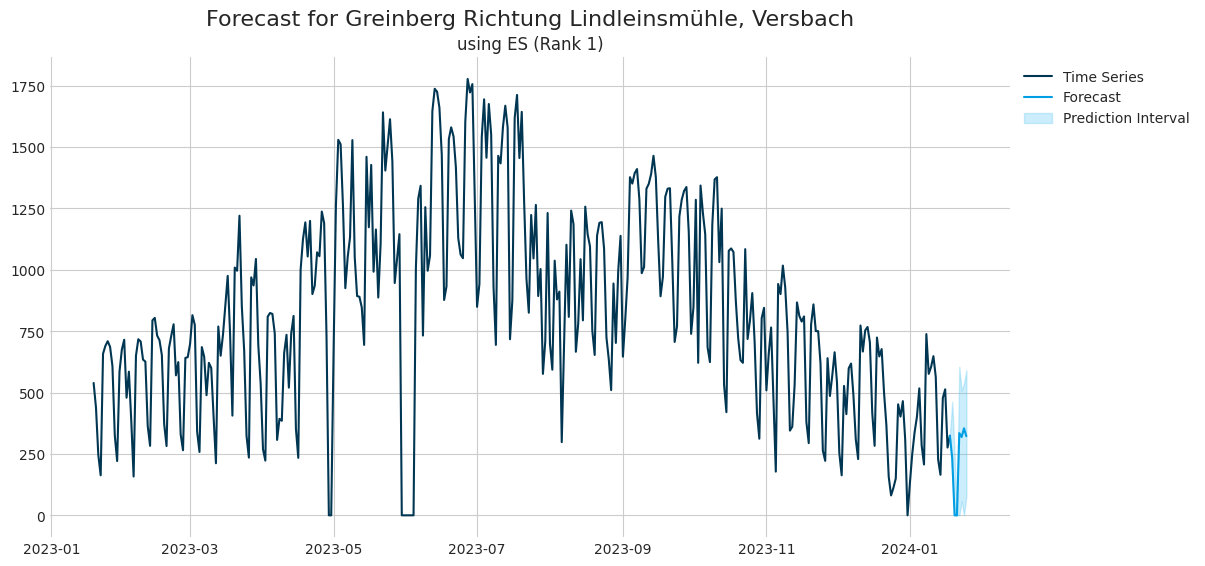

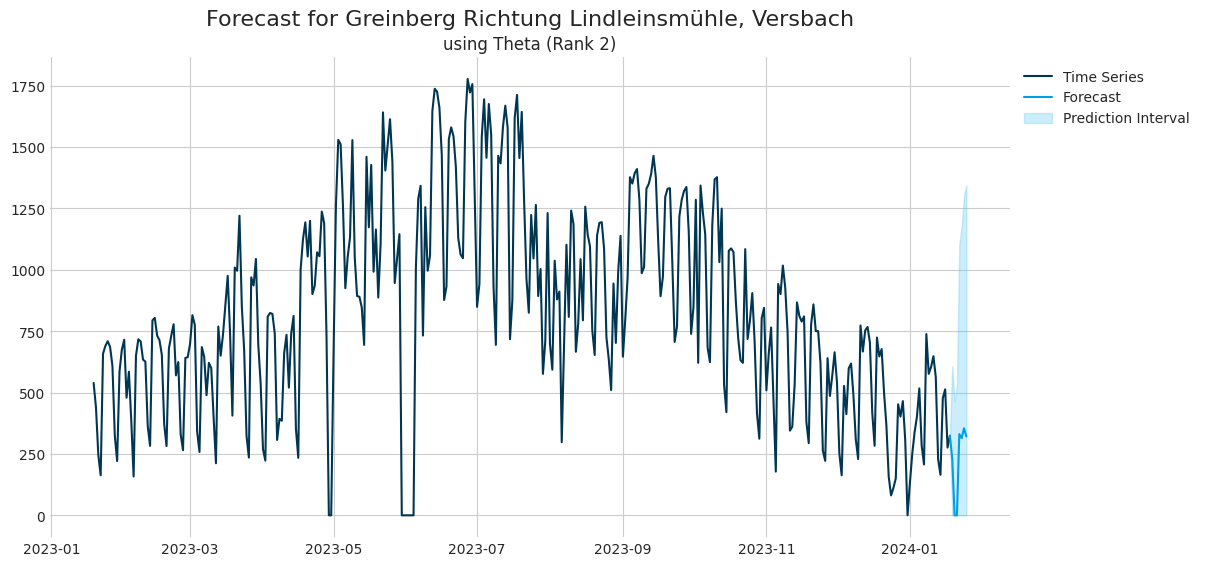

In [5]:
from futureexpert import plot

forecasts = results[0]
plot.plot_forecast(forecasts, plot_last_x_data_points_only=365, ranks=[1,2])

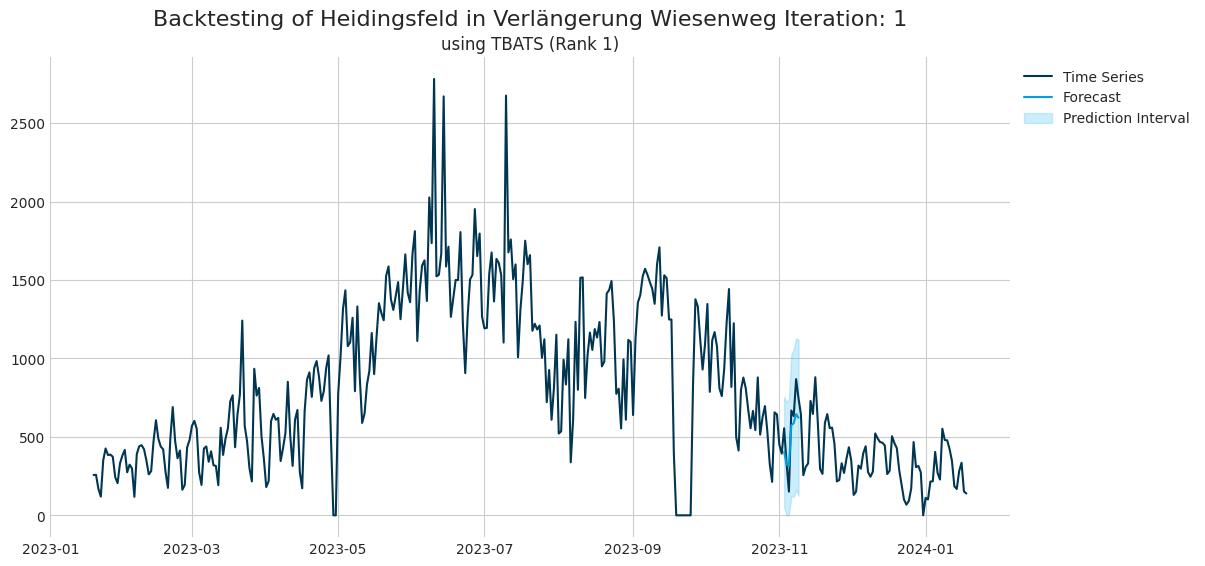

In [9]:
from futureexpert import plot

forecasts = results[0]
plot.plot_backtesting(forecasts, iteration=1, plot_last_x_data_points_only=365)